In [1]:
#PERF: If the Ridge or ENet regressions cause a "Dead Kernel", lower the number of nlambda to 100
#PERF:  If on Mac the kernel restarts on the alpha-lambda grid, go to 5 folds

suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(require(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(glmnet, quietly = TRUE, warn.conflicts = FALSE))
set.seed(2718281)


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand


Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loaded glmnet 2.0-16



### In this module you will learn:

1. How to work with real data to build a prediction model
2. We will build a hedonic model model for house prices 
3. In building this model we will explore different penalty methods including LASSO, Ridge, and Elastic-Net

### Housing Price Data

The following data is from the 2011 metropolitan sample of the American Housing Survey (Mullainathan Spiess 2017)

In [2]:
Housing = read_csv(unzip('ahs_clean.zip'))
# Reads csv files into R

Housing[1:10,1:10]                                  
# Examine the first few rows and columns of our data   

cat('Dataset dimesions: ',dim(Housing))                  
# Returns the dimension of the dataset             

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


LOGVALUE,LOT,UNITSF,CLIMB,DIRAC,NUMAIR,BUSPER,EXCLUS,HOWH,NUMCOLD
0.6931472,900,2314.18,2.011952,1.51928,1.730885,0,0,6,1.828194
0.6931472,14520,2500.00,2.011952,1.51928,1.730885,0,0,10,1.828194
0.6931472,11000,7507.00,2.011952,1.51928,1.000000,0,0,9,1.828194
1.6094379,23760,830.00,2.011952,1.51928,1.000000,0,0,10,1.828194
1.6094379,3000,1100.00,2.011952,1.51928,4.000000,0,0,7,1.828194
1.6094379,44000,1000.00,2.011952,1.51928,1.730885,0,0,6,1.828194
1.6094379,220000,2000.00,2.011952,1.51928,1.000000,1,0,8,1.828194
1.6094379,220000,1800.00,2.011952,1.51928,1.730885,0,0,10,1.828194
1.6094379,33000,1200.00,2.011952,1.51928,1.730885,1,0,10,1.828194
1.9459101,44000,1957.00,2.011952,1.51928,1.730885,0,0,8,1.828194


Dataset dimesions:  51759 212

## Examining the Data

This isn't a huge dataset, but it's big enough where just looking at the spreadsheet isn't very informative. There are 212 covariates and 51,759 households. 

## Visualization and Descriptive Statistics

Instead of simply looking at the data table, let's start visualizing the distributions of some covariates. To get an idea of how we might do this consider some of the most important features of a house: Bedrooms, Full Bathrooms, Acreage, and Finished Area. 

Let's plot the first two using bar plots and the later two with histograms. In addition we can look at the Five Number Summary for each of these covariates.

[1] "BEDRMS"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   3.000   3.213   4.000   8.000 

[1] "BATHS"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   1.917   2.000  10.000 

[1] "LOT"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    200    6000   11000   44455   43926  933185 

[1] "UNITSF"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     99    1400    2000    2325    2500   20159 

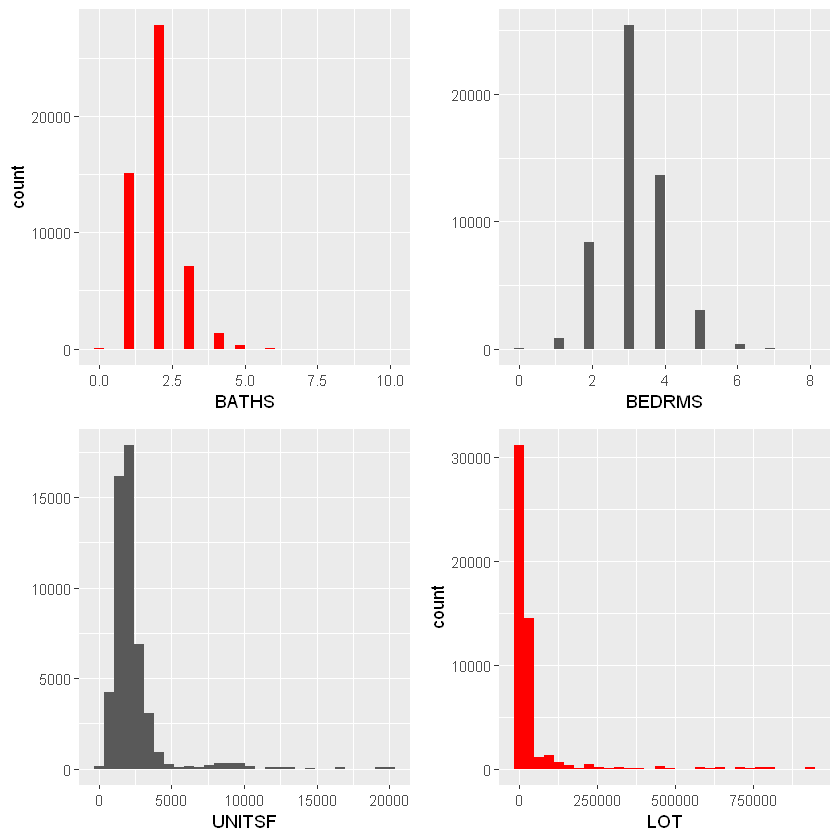

In [3]:
p1 = ggplot(Housing,aes(BATHS)) + geom_histogram(bins=30,fill='red')     
# full ggplot command
p2 = qplot(BEDRMS,data=Housing,bins=30)                                  
# qplot will do this automatically
p3 = qplot(UNITSF,data=Housing,bins=30)
p4 = ggplot(Housing,aes(LOT)) + geom_histogram(bins=30,fill='red')     

grid.arrange(p1,p2,p3,p4,ncol=2)

print('BEDRMS')
summary(Housing$BEDRMS)

p1 = ggplot(Housing,aes(BATHS)) 
print('BATHS')
summary(Housing$BATHS)
print('LOT')
summary(Housing$LOT)
print('UNITSF')
summary(Housing$UNITSF)

### What do we see?

Most houses have 2 Bedrooms and 3 Bathrooms. The distributions for acreage (LOT) and finished area (UNITSF) are non-negative and heavily skewed right. In this case it might be a good idea to take logarithms of both of these variables to reduce the impact of long tails in our analysis.

### Data Transformation

Let's transform and re-examine the distribution.

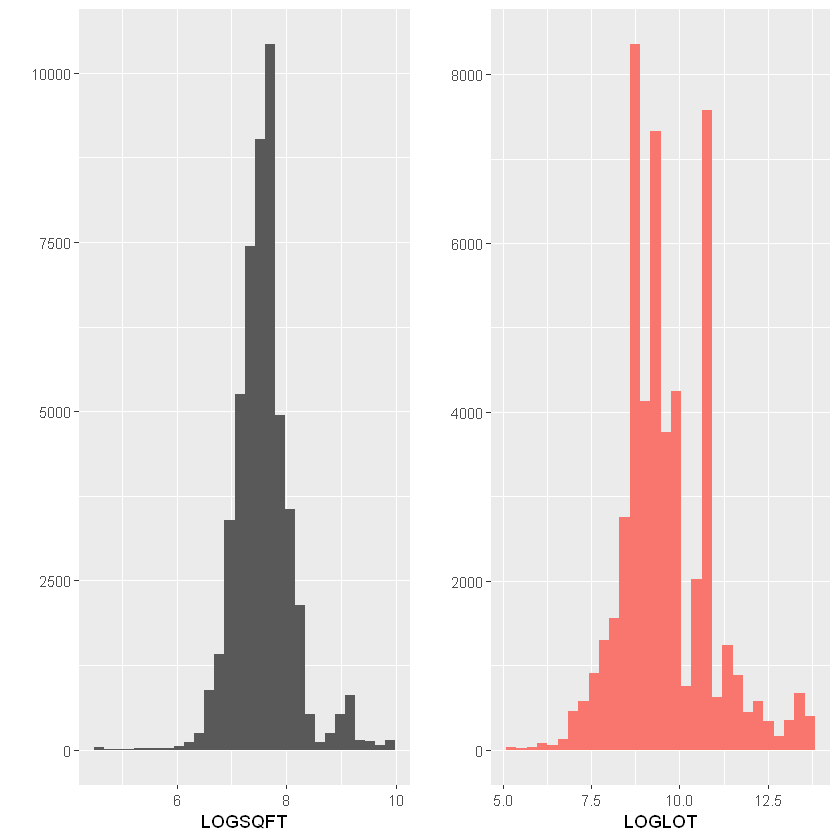

In [4]:

Housing$LOGSQFT = log(Housing$UNITSF)
Housing$LOGLOT = log(Housing$LOT)

p1 = qplot(LOGSQFT,data=Housing,bins=30)
p2 = qplot(LOGLOT,data=Housing,bins=30,fill='red') + guides(fill=FALSE)
grid.arrange(p1,p2,ncol=2)



The transformation nearly elminates the right skew. Let's go ahead and look at the relationships between these variables and the housing price.

### Visualization in High Dimensions

Even when we don't have a huge sample, it can be helpful to use subsamples to visualize the data. To see this, let's randomly select half of the observations to plot. 



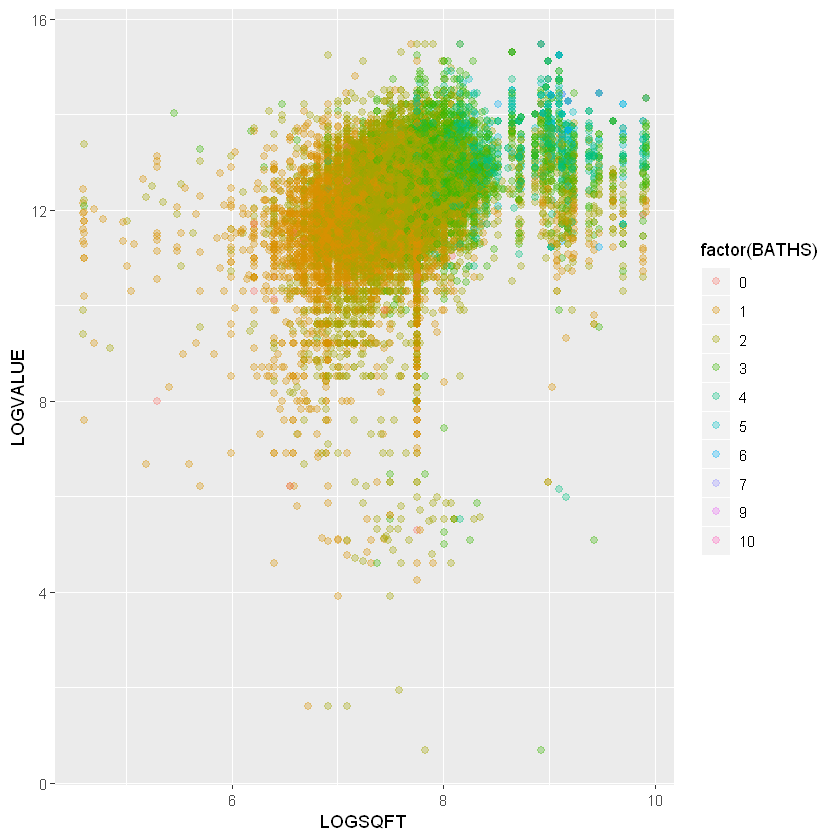

In [5]:


subset = Housing[sample(1:nrow(Housing),dim(Housing)[1]*.5),]

ggplot(subset , aes(x = LOGSQFT, y = LOGVALUE)) +             
# Plotting relationship between Finished Area and log(price)
           geom_point(aes(color = factor(BATHS)),alpha=.3,size=2)       
# Color based on number of full bathrooms


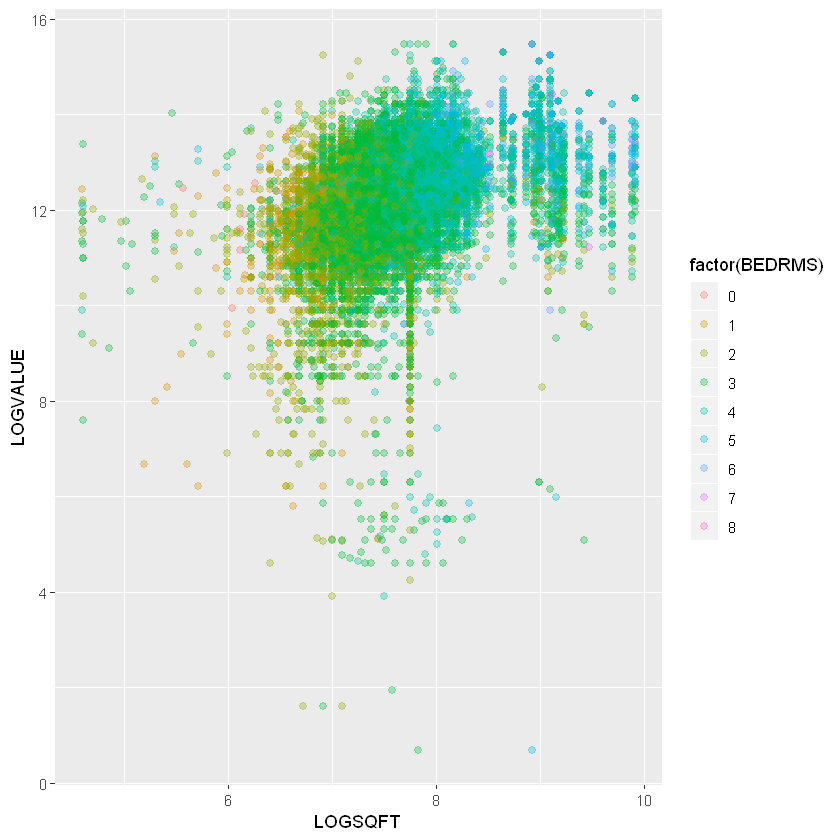

In [6]:
ggplot(subset , aes(x = LOGSQFT, y = LOGVALUE)) +        
# Plotting relationship between Finished Area and log(price)
           geom_point(aes(color = factor(BEDRMS)),alpha=.3,size=2)  
# Color based on number of bedrooms


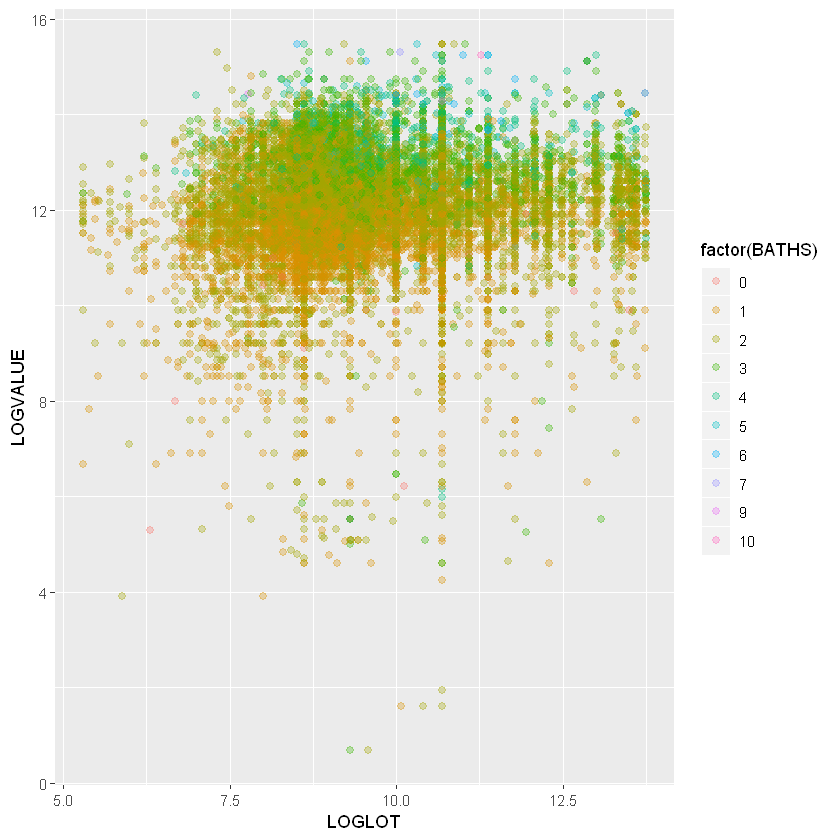

In [7]:
ggplot(subset , aes(x = LOGLOT, y = LOGVALUE)) +            
# Plotting relationshipo between Acreage and log(price)
           geom_point(aes(color = factor(BATHS)),alpha=.3,size=2)   
# Color based on number of full bathrooms


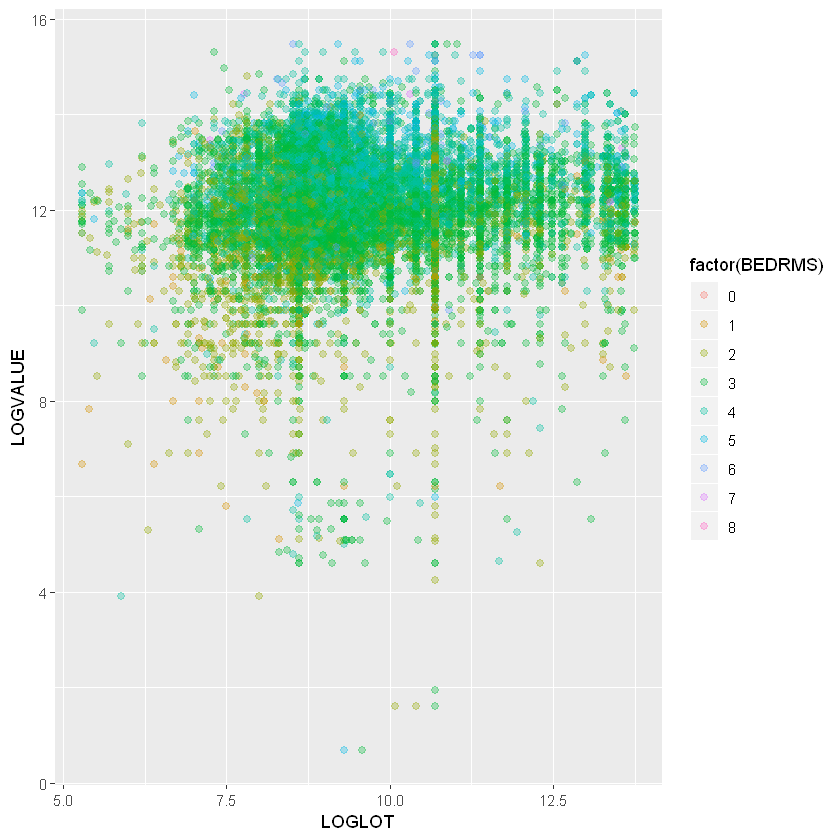

In [8]:
ggplot(subset , aes(x = LOGLOT, y = LOGVALUE)) +              
# Plotting relationshipo between Acreage and log(price)
           geom_point(aes(color = factor(BEDRMS)),alpha=.3,size=2)       
# Color based on number of bedrooms


## What do we see?

We observe what we expect, houses with larger finished areas have more bedrooms and bathrooms. The results are much less clear between acreage and bathrooms and bedrooms which is intuitive as well.

It looks like there is a positive correlation between each of these covariates with price, but it is difficult to tease out relationships solely based on bivariate plots. Let's start running some regressions.

## Validation Set

First let's separate 10% of our sample as a validation set as before.

In [9]:
#Splitting the data

data_split = function(data,split=.1){

    N = dim(data)[1]                         
    random = sample(1:N,N,replace=F)         
    # Randomly choose the index for the splits
    data = data[random,]                      
    # Shuffle data
    test = data[1:round(N*split),]            
    # Splits
    train = data[(round(N*split)+1):N,]

    
    return(list(train,test))
}


tmp = data_split(Housing) 
train_test = tmp[[1]]
validation = tmp[[2]]


## Our First Regression

The first model we are running is $\log(value) = \beta_0 +\beta_1 \log(lot) + \beta_2 \log(sqft) + \beta_3 bedrooms + \beta_4 bathrooms + \varepsilon$

Once again we are going to evaluate the performance of this model based on cross-validation. However, this time instead of writing our own cross-validation function let's utilize the one built into the "caret" package.

## First Steps with Caret

The "train" function is a highly flexible way to estimate different models with various options. Here we are just running OLS so the method is "lm" (linear model). The cross-validation setting is inside the "trainControl" option. We specify "cv" for cross-validation and the number of folds to be 5.

In [10]:

train1 = train_test[c('LOGVALUE','LOGLOT','LOGSQFT','BEDRMS','BATHS')]

model <- train(
  LOGVALUE ~.,data = train1,               
    # formula for the model
  method = "lm",                           
    # OLS
  trControl = trainControl(
    method = "cv", number = 5,             
      # 5 fold cross-validatoin
  )
)

model

Linear Regression 

46583 samples
    4 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 37267, 37266, 37265, 37266, 37268 
Resampling results:

  RMSE       Rsquared   MAE      
  0.9040722  0.1938213  0.6093896

Tuning parameter 'intercept' was held constant at a value of TRUE

## First Regression Results

The results aren't great here, but we also are only taking into account a few of the covariates.
Let's add in some of the location and house attributes.

## Building Richer Models

We can directly add the variables by their names by adding the columns to the training data.

In [11]:
train2 = cbind(train1,train_test[c('REGION','METRO','KITCHEN','DISH',
                                   'WASH','DRY','COOK','DENS','DINING',
                                   'FAMRM','HALFB','LIVING','OTHFN',
                                   'RECRM','PORCH','SINK','LAUNDY',
                                   'FLOORS','CONDO','ROOMS','PLUMB',
                                   'NOWIRE','AGE')])
model <- train(
  LOGVALUE ~ .,data = train2 ,
  method = "lm",
  trControl = trainControl(
    method = "cv", number = 5,
  )
)


model

Linear Regression 

46583 samples
   27 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 37266, 37266, 37267, 37267, 37266 
Resampling results:

  RMSE       Rsquared   MAE      
  0.8335495  0.3146981  0.5534109

Tuning parameter 'intercept' was held constant at a value of TRUE

The RMSE, MAE, and Rsquared improve a bit here. We still have a lot of covariates we can consider though.

Let's add a few more features to see if we can get better results.

## Tricks to Select Data

Another way to select covariates in a data.frame is with "select". Here we are selecting all the covariates that have names beginning with "Roach","Rats","Water","Num", and "Freeze".

In [12]:
train3 = cbind(train2,select(train_test,starts_with('Roach')),
                   select(train_test,starts_with('Rats')),
              select(train_test,starts_with('Water')),
                   select(train_test,starts_with('Cellar')),
               select(train_test,starts_with('Num')),
                   select(train_test,starts_with('Freeze')))

model <- train(
  LOGVALUE ~ .,data = train3 ,
  method = "lm",
  trControl = trainControl(
    method = "cv", number = 5,
  )
)


model

Linear Regression 

46583 samples
   60 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 37266, 37266, 37265, 37268, 37267 
Resampling results:

  RMSE       Rsquared   MAE      
  0.7942429  0.3777571  0.5323808

Tuning parameter 'intercept' was held constant at a value of TRUE

This model has 60 predictors. This isn't huge on it's own, but you could imagine by adding interactions and power terms the number of predictors would increase very fast.

## Shrinkage in R

Once we have included all the covariates that we believe may be related to the model, we may want to apply a penalty term to improve out-of-sample performance. R makes this very easy for all generalized linear models with the "glmnet" package.

Let's go ahead and run a LASSO regression on the last model we looked at.

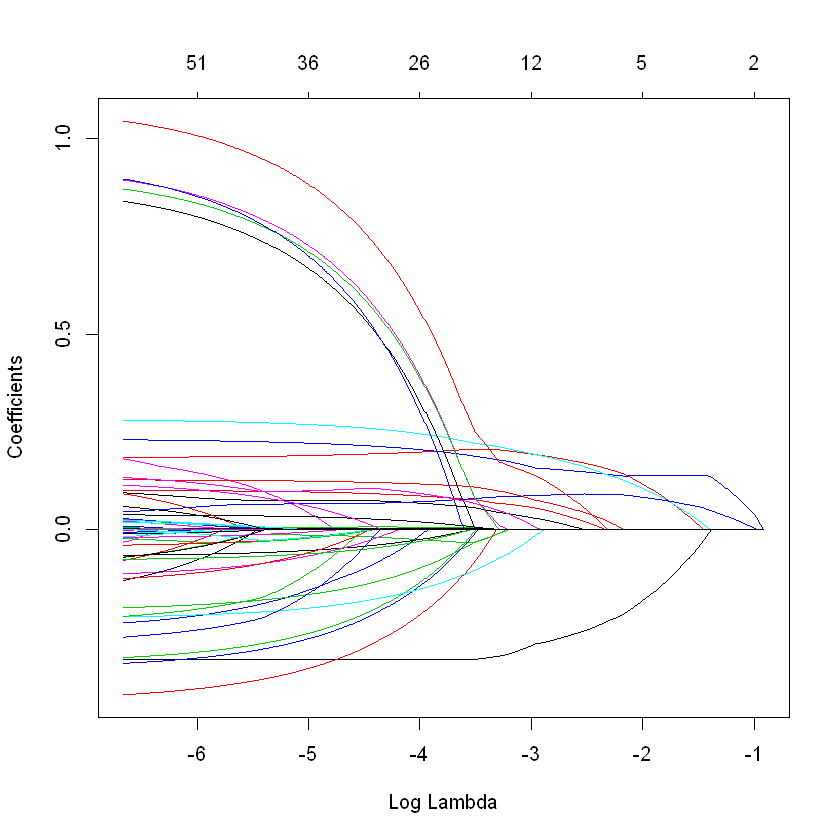

In [13]:
y = as.double(as.matrix(train3$LOGVALUE))                                     
# convert data.frame to matrix for use w/ glmnet
x = as.matrix(train3[,-1])

# alpha = 1 corresponds to Lasso

cv.lasso =cv.glmnet(x, y, family='gaussian', alpha=1, nfolds=5, nlambda=1000)             
# This will automatically cross-validate and                            
# optimize over a grid of penalty weights                            

# The plots are with respect to penalty weights

plot(cv.lasso$glmnet.fit, xvar="lambda")                                    
# The value of the estimated coefficients


## LASSO Results

We observe quite a few coefficients go to zero for small values of $\lambda$, but many of them are just shrinking slowly to $0$

The same function works with other shrinkage penalties like Ridge and Elastic-Net.

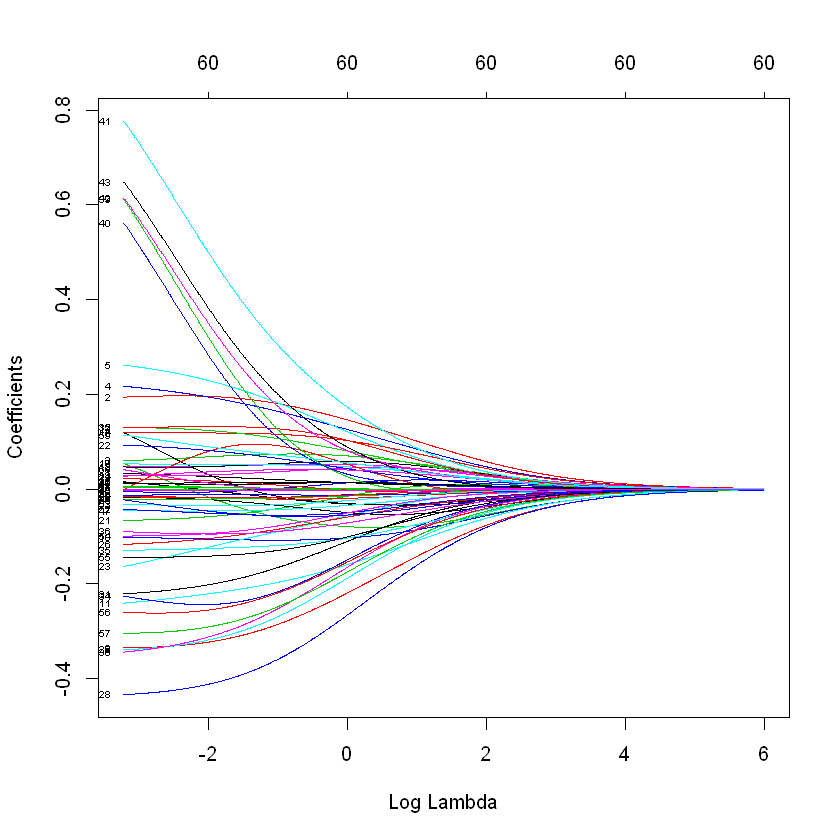

In [14]:
# alpha = 0 corresponds to Ridge

cv.ridge =cv.glmnet(x, y, family='gaussian', alpha=0, nfolds=5, nlambda = 1000)
plot(cv.ridge$glmnet.fit, xvar="lambda", label=TRUE)


## Ridge Regression

The coefficient paths are distinctly different for the lasso and ridge regressions. The ridge penalty shrinks all the coefficients gradually to zero, while the lasso sets them to zero at different rates and is much sharper.

We can also consider an elastic-net type regression where we have both ridge and lasso penalties.

The $\alpha$ parameter determines the weight between the ridge and lasso penalties

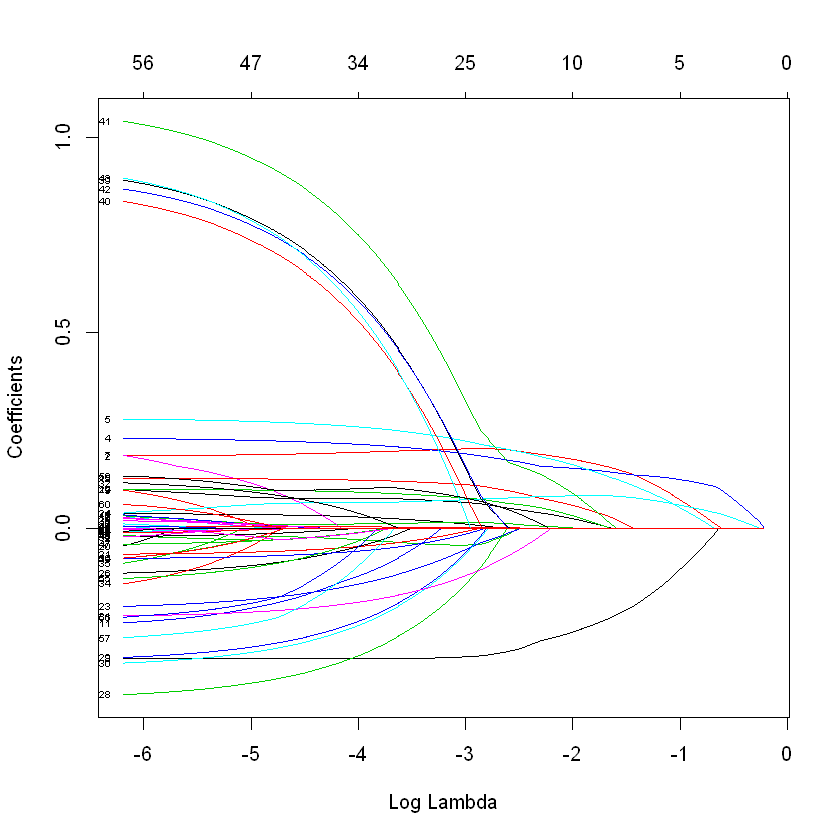

In [15]:
# alpha = .5 corresponds to a type of elastic-net, 
# the ridge and lasso penalty terms have equal weights

cv.enet =cv.glmnet(x, y, family='gaussian', alpha=.5, nlambda = 1000)

plot(cv.enet$glmnet.fit, xvar="lambda", label=TRUE)


## Elastic-Net

The coefficient paths look exactly like a combination of the ridge and lasso shrinkage.

## OLS vs Shrinkage

Comparing the results between OLS, Lasso, Ridge, and Elastic-Net ($\alpha=0.5$)

In [16]:
cat('OLS RMSE: ', model$results$RMSE)
cat('\nLasso RMSE: ', sqrt(min(cv.lasso$cvm)),
    ', corresponding to Lambda: ', cv.lasso$lambda.min)
cat('\nRidge RMSE: ' , sqrt(min(cv.ridge$cvm)),
    ', corresponding to Lambda: ', cv.ridge$lambda.min)
cat('\nENet RMSE: ' , sqrt(min(cv.ridge$cvm)),
    ', corresponding to Lambda: ', cv.enet$lambda.min)


OLS RMSE:  0.7942429
Lasso RMSE:  0.7944764 , corresponding to Lambda:  0.001384465
Ridge RMSE:  0.7979806 , corresponding to Lambda:  0.04090276
ENet RMSE:  0.7979806 , corresponding to Lambda:  0.00254845



OLS is holding its own with the competing models on this metric.

## Cross-Validation for $\alpha$ and $\lambda$

It is possible that different combinations of alpha and lambda might produce better results. Let's go back to using the caret cross-validation package to tune $\alpha$ and $\lambda$ pairs.

We have already observed that the better performance is obtained for small values of lambda, lets vary alpha over this range.

In [17]:
model.shrinkage <- train(
  LOGVALUE ~ .,data = train3,
  method = "glmnet",                                                   
# method is no longer least squares
  tuneGrid = expand.grid(alpha = seq(0,1,.1),                        
# We are specifying the grid to be between [.1,.9]
                        lambda = seq(.001,.002,.0001)),
# "" [.001,.002] stepsizes are .1 and .0001 resp.
  trControl = trainControl(
    method = "cv", number = 10,
  )
)



In [18]:
print('OLS')
model$results[which.min(model$results$RMSE),]
print('Shrinkage')
model.shrinkage$results[which.min(model.shrinkage$results$RMSE),]


[1] "OLS"


intercept,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
TRUE,0.7942429,0.3777571,0.5323808,0.009520464,0.01023753,0.001800286


[1] "Shrinkage"


,alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
67,0.6,0.001,0.7938515,0.3782261,0.5320908,0.02569698,0.01634555,0.008811891


## Validation Results

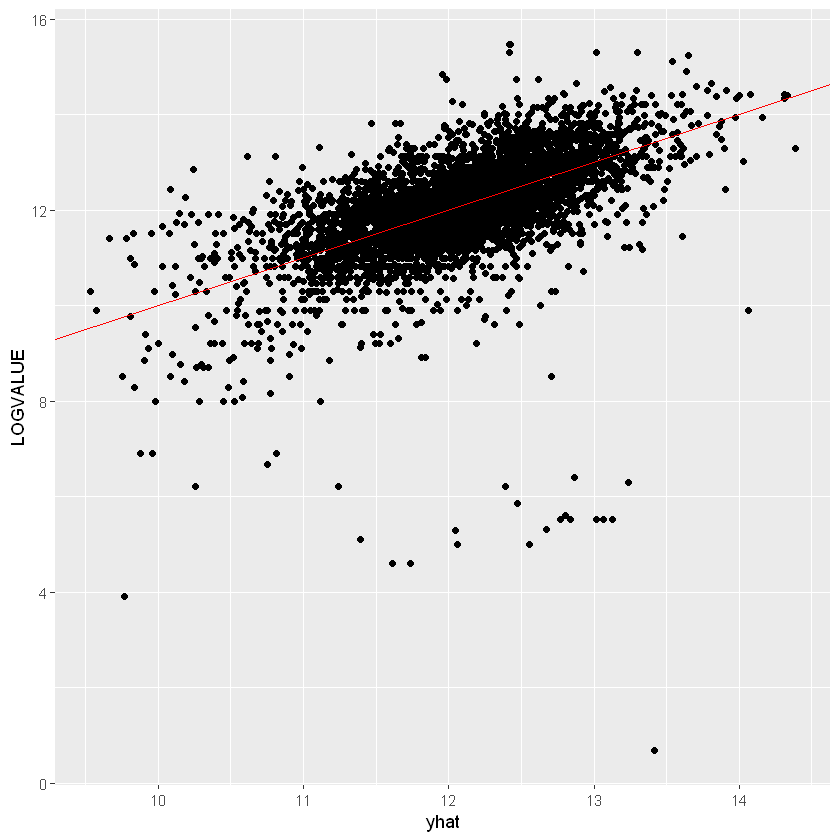

In [19]:
yhat = predict(model.shrinkage,newdata=validation)
out = cbind(yhat,validation)
ggplot(out, aes(yhat,LOGVALUE)) + geom_point() + geom_abline(slope=1,color='red')

Not too bad! A perfect prediction would have all the points falling on the red line, but we are capturing a lot of the variation in the data.

## Exercise: Module 2

We have seen how to run a linear regression in R and use it to predict housing prices. In the course material we examined the role of shrinkage in alleviating instability of OLS when the number of parameters is large relative to the sample size. To see how this might help in practice let's consider a random subsample of this data ($10\%$)

1. Run OLS, Lasso, Ridge, and Elastic-Net ($\alpha=.5$)
2. What shrinkage parameters get selected?
3. Which model does best in terms of out-of-sample performance?
4. Do you notice a significant performance increase between the shrinkage estimators and OLS?

It appears that LASSO, Ridge and ENet all perform fairly similar with a slight edge going to LASSO. We do notice that OLS is quite unstable in this case as the proportion of covariates to sample size is much larger when we subsample.